In [1]:
import time
startTime = time.time()

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, nquad, dblquad
from scipy.special import ellipe, ellipk
from scipy.interpolate import lagrange, InterpolatedUnivariateSpline
from scipy.signal import savgol_filter

## User input

In [2]:
# Gas:
# Conversion to linear scale was made in the notebook: grav_project/NGC_5005/Gas_from_mass_surface_density.ipynb
raddens = "../data/gasmsd_kpc_linear.txt"      # Gas density with 2 columns, units: KPC, MSUN/PC^2
maxkpc=11
minkpc=.9473
# Parameters
z0 = 0.93

#constants
G = 0.00000431158                   # Gravitational constant (KPC/MSUN*(KM/S)^2)  

In [3]:
# Gas
tracedgas = np.loadtxt("../NGC_5005/traced_data/ngc5005_gas.txt")
radii, tracedgas_v = tracedgas.T
radii = radii[1:]
tracedgas_v = tracedgas_v[1:]

## Density profile, outputs: radii (array), densities (array), rcut (one #), delta (one #)

In [4]:
def DensityProfile(raddens=raddens):
    mudata = np.loadtxt(raddens)     
    xdinp, ydinp = mudata.T
    rcut = xdinp[len(xdinp)-1]               # rcut is the LAST radius value (?)
    delta = rcut - xdinp[len(xdinp)-2]       # difference between the last two radius values
    
    return xdinp, ydinp, rcut, delta

#defining these output values:
# Radius
xdinp = DensityProfile()[0]
# Density
ydinp = DensityProfile()[1]
# Cutoff radius
rcut = DensityProfile()[2]
# Cutoff length
delta = DensityProfile()[3]

## Interpolation

In [5]:
def interpd(x,y):
    #return lagrange(x,y)                # Lagrange interpolation didn't work well so I used Univariate Spline
    return InterpolatedUnivariateSpline(x,y,k=4)
    
# Calculate the density values at the sampling radii
spline_rhor = interpd(xdinp,ydinp)        # define the polynomial that's calculated

radii = np.arange(0.001,11,0.1)                # Sampling radii
## Partial derivative / Smoothing

In [6]:
#radii = np.linspace(0.001,maxkpc,100)                # Sampling radii
#radii = np.arange(minkpc,maxkpc,0.1)                # Sampling radii

# Partial derivative of rho(u,z) with respect to u
# Taking the derivative of the splined polynomial (radius and density values, rho(r) or rho(u))
drho_du = spline_rhor.derivative()

# Evaluating at given radii
drho_du_values = drho_du(radii)

# Smoothing: Savitzky-Golay filter: https://riptutorial.com/scipy/example/15878/using-a-savitzky-golay-filter
drho_du_smooth = savgol_filter(drho_du_values, 11, 5)  # window size 11, polynomial order 6

# Spline the smoothed derivative
spline_drhor = interpd(radii,drho_du_smooth)

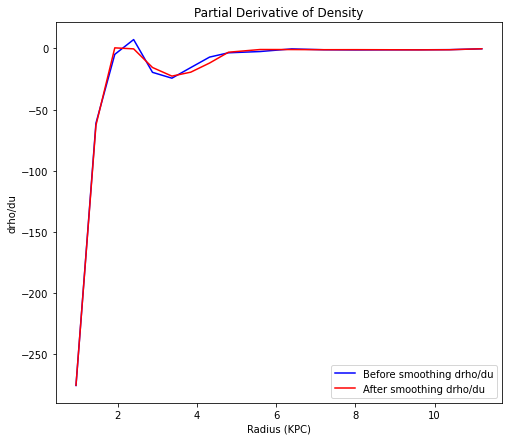

In [7]:
# Plot 
plt.figure(figsize=(8,7))
plt.plot(radii,drho_du_values, label="Before smoothing drho/du", c="blue")
plt.plot(radii,drho_du_smooth, label="After smoothing drho/du", c="red")
#plt.plot(radii,spline_drhor(radii), label="After smoothing and splining drho/du", c="purple")
plt.title("Partial Derivative of Density")
plt.xlabel("Radius (KPC)")
plt.ylabel("drho/du")
plt.legend()
plt.show()

## Functions

In [8]:
#from casertano http://articles.adsabs.harvard.edu/pdf/1983MNRAS.203..735C
# Casertano Eq 2
def drho_du(z,u):
    return spline_drhor(u) * np.cosh(z /z0)**(-2)

print(drho_du(1,1))

-90.77944368790979


In [9]:
# Casertano Eq 5
def px(z,u,r):
    x = (r**2 + u**2 + z**2)/(2*r*u)
    return x - np.sqrt((x**2)-1)

print(px(1,1,1))

0.3819660112501051


In [10]:
# Complete elliptic integral
def K_E(z,u,r):
    return ellipk(px(z,u,r)) - ellipe(px(z,u,r))

print(K_E(1,1,1))


0.35734399698214614


In [11]:
#casertano eq 4, simplified
integrand = lambda z,u,r:(8 *G) * drho_du(u,z) * K_E(z,u,r) / np.sqrt(u/(r * px(z,u,r)))

print(integrand(1,1,1))

-0.0006915328307731284


In [12]:
# Define minimum and maximum values of radius for integration
intmin = 0.01 #0 causes runtime issues but this gets very close
intmax = 1e3 #np.max(radii) #Integration is from 0 to infinity but infinity gives overflow errors so we just pick the largest we can without causing errors

# Reverse order of variables to setup for integration
radialforce = lambda r: dblquad(integrand, intmin, intmax,lambda u:intmin,lambda u:intmax, args=(r,))[0]
print(radialforce)
print(radialforce(1))
radialforce = np.vectorize(radialforce)
print(radialforce)
print(radii)

F = radialforce(radii) #save this since it's called a few times
print(F)

<function <lambda> at 0x7fbf0145b320>


/home/gerudo7/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in cosh
  after removing the cwd from sys.path.
/home/gerudo7/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  **opt)
/home/gerudo7/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)


0.49886103164232615
[ 0.9464  1.4501  1.9258  2.4017  2.8777  3.3677  3.8435  4.3193  4.7951
  5.5927  6.3905  7.2022  7.9999  8.7837  9.5954 10.3792 11.1908]
[ 0.4460032   1.05882177  1.8749379   2.9211795   4.19730081  5.75084427
  7.49226945  9.46318385 11.66357414 15.86685711 20.71602737 26.31127012
 32.45982869 39.12832609 46.68892006 54.62143457 63.48897436]


## Velocity

In [13]:
#casertano eq 6:
print(radii)
velocs = (radii*F)**(0.5)
scale = 1
velocs=velocs*scale
print(velocs)

[ 0.9464  1.4501  1.9258  2.4017  2.8777  3.3677  3.8435  4.3193  4.7951
  5.5927  6.3905  7.2022  7.9999  8.7837  9.5954 10.3792 11.1908]
[ 0.64969025  1.23911156  1.90019878  2.64873494  3.47542408  4.40080882
  5.36624055  6.39330353  7.47850282  9.42011527 11.50590166 13.76586465
 16.11444642 18.53891793 21.16598364 23.81022456 26.65506358]


## More troubleshooting: comparing the F(r) functions

In [14]:
tracedgas_F=tracedgas_v**2/-radii

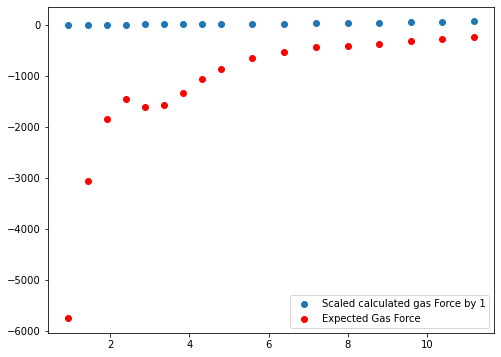

In [15]:
plt.figure(figsize=(8,6))             
plt.scatter(radii,scale*np.asarray(F), linestyle='solid', label='Scaled calculated gas Force by {}'.format(scale))
plt.scatter(radii, tracedgas_F, label='Expected Gas Force', c='red')
plt.legend(fontsize=10)

## Plot

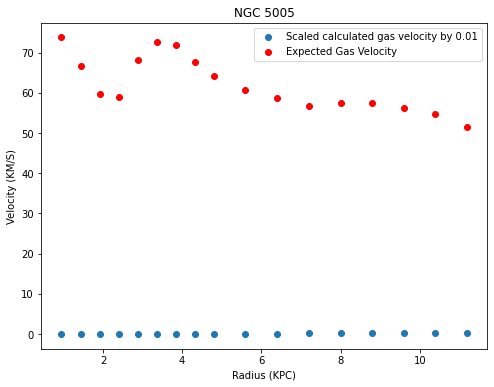

[0.0064969  0.01239112 0.01900199 0.02648735 0.03475424 0.04400809
 0.05366241 0.06393304 0.07478503 0.09420115 0.11505902 0.13765865
 0.16114446 0.18538918 0.21165984 0.23810225 0.26655064]
[73.7665 66.7029 59.6362 58.9752 68.2788 72.6015 71.9405 67.7208 64.213
 60.7393 58.6894 56.6408 57.4377 57.5213 56.1846 54.8448 51.3727]
[ 0.9464  1.4501  1.9258  2.4017  2.8777  3.3677  3.8435  4.3193  4.7951
  5.5927  6.3905  7.2022  7.9999  8.7837  9.5954 10.3792 11.1908]


In [16]:
scale=.01
actvelocs=scale*np.asarray(velocs)
plt.figure(figsize=(8,6))             
plt.scatter(radii, actvelocs, linestyle='solid', label='Scaled calculated gas velocity by {}'.format(scale))
#plt.plot(radii, 1e3*velocs_smooth, linestyle='solid', label='Smoothed Gas Velocity')
plt.scatter(radii, tracedgas_v, label='Expected Gas Velocity', c='red')
plt.axis('tight');
plt.title('NGC 5005')
plt.xlabel('Radius (KPC)', fontsize=10)
plt.ylabel('Velocity (KM/S)', fontsize=10)
plt.legend(fontsize=10)
#plt.xlim(0,12)
plt.show()
print(actvelocs)
print(tracedgas_v)
print(radii)

In [17]:

executionTime = (time.time() - startTime)
print('Execution time in minutes: ' + str(executionTime/60))

Execution time in minutes: 8.527090577284495
